Via two methods, we process the results of time interval selection, and prepare for AIA data prep and/or DEM calculation.

The two methods are:

1. Prepping AIA regions for NCCS, using existing downloaded sample AIA files.
2. Preparing AIA regions for use as DEM inputs (AIA data will be downloaded and prepped inside DEM code, with the JSOC as the data source).

The first method was the original. It is used when there is data available on the NCCS (original sample), and when the region method is either 'fit' or 'double' (both gaussian fit based methods).

The second method is used when NCCS data is not available, and for ALL cases with the "manual" method. The on-NCCS manual cases could be re-done on the NCCS if ever desired. They used method 2 because a previous issue with “manual” regions was identified via the new data analysis, and a corrected method developed then was used for all manual methods. The problem was: use of the all-orbit region files saved in the top level directory meant that the regions shifted in time given the motion of the Sun in RA-DEC, becoming notably less accurate at the edges of the orbit. The difference between the actual observing time and the orbit midtime (up to ~30 min) made this significant in some cases. We re-did the AIA prep via the JSOC method for all the manual keys. 

Note that for the latter method, DEMs will also be called separately for each region. See this (and the other methods) implemented in run_dodem_three_ways.ipynb. 

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

# #import nustar_dem_prep as nu
import images_and_coalignment as iac
#import time_interval_selection as tis
import all_nu_analysis as ana
import nustar_utilities as nuutil
import gauss2D as g2d
import nustar_dem_prep as nu


# import os
# # For macOS
# def play_sound():
#     os.system("afplay /System/Library/Sounds/Glass.aiff")

import pickle
import pathlib
import importlib
from astropy import units as u
import numpy as np


Method 1: prepping AIA regions for NCCS, using existing downloaded sample AIA files.

In [2]:
# key = '30-jul-21_1'
# #file = '/all_targets.pickle'
# file='/Users/jmdunca2/do-dem/reference_files/all_targets_postghost_postshut.pickle'


# with open(file, 'rb') as f:
#     data = pickle.load(f)
    
# ARDict = data[key]

# id_dirs = ARDict['datapaths']
# obsids = ARDict['obsids']
# working_dir = ARDict['working_dir']
# method = ARDict['method']

# if method=='double':
#     gauss_stats = ARDict['gauss_stats']
#     sep_axis = gauss_stats[0][0]
# else:
#     sep_axis = ''

# #Save information about the successful time intervals from the TIS run earlier.
# ana.post_tis_info_dump(key, file)

# with open(file, 'rb') as f:
#     data = pickle.load(f)
    
# ARDict = data[key]

In [3]:
# obsids=[]
# for id in id_dirs:
#     evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
#     obsids.append(obsid)
#     time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
#     timerange = [time0, time1]
#     print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    

In [4]:
# importlib.reload(iac)
# aia_dir = '/Users/jmdunca2/sample_aia/sample_aia/'


# aiamaps = iac.get_orbit_aiamaps(aia_dir, id_dirs, wave=94)   

Goal: write a combined fundtion that, for any number of regions found via any method, plots nustar contours over aia data with all regions shown. 
- In the case of multiple regions (and therefore, multiple different sets of time intervals per orbit), choose the longest time interval for the NuSTAR data.
- In the case where some of the orbits failed TIS for some regions, account for this (only plot sucessful-TIS regions). 

In [5]:
# importlib.reload(iac)
# aati = iac.per_orbit_region_adjustment(ARDict, 0, aiamaps, 
#                                        nushift=[0, 0], method=method, shush=True, sep_axis=sep_axis)



In [6]:
# region_dirs = ARDict['directories']
# all_all_time_intervals = ARDict['per_region_all_time_intervals']
# for i in range(0, len(all_all_time_intervals)):
#     suborbit_dirs = iac.make_all_aia_dicts(all_all_time_intervals[i], region_dirs[i], key, additional_path=working_dir)

Method 2: preparing AIA regions for use as DEM inputs (AIA data will be downloaded and prepped inside DEM code, with the JSOC as the data source). Sample file is downloaded here. 

In [7]:
key = '09-dec-22'
#file = '/all_targets.pickle'
file='/Users/jmdunca2/do-dem/reference_files/all_targets_postghost_postshut.pickle'


with open(file, 'rb') as f:
    all_targets = pickle.load(f)
    
ARDict = all_targets[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']
method = ARDict['method']

if method=='double':
    gauss_stats = ARDict['gauss_stats']
    sep_axis = gauss_stats[0][0]
else:
    sep_axis = ''

#Save information about the successful time intervals from the TIS run earlier.
ana.post_tis_info_dump(key, file)

with open(file, 'rb') as f:
    all_targets = pickle.load(f)
    
ARDict = all_targets[key]

In [8]:
#this basically just prints the orbit times for reference
obsids=[]
for id in id_dirs:
    evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
    obsids.append(obsid)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    

23-38-39 00-39-45


In [9]:
#Get sample AIA files for each orbit!

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

from aiapy.calibrate.util import get_correction_table, get_pointing_table
from aiapy.calibrate import register, update_pointing, degradation, estimate_error

aagt = ARDict['per_region_all_time_intervals']

aiamaps=[]
for i in range(0, len(id_dirs)):
    try:
        #First region, orbit of interest, first time interval, start time of that interval
        start_time = aagt[0][i][0][0]
        print(start_time)
        
        jsoc_email='jessie.m.duncan@nasa.gov'
    
    
        #Get single full-disk 94 for region adjustment selection
        query = Fido.search(
            #a.Time(start_time+10*u.min, start_time + 11*u.min),
            a.Time(start_time, start_time + 10*u.s),
            a.Wavelength(94*u.angstrom),
            a.jsoc.Series.aia_lev1_euv_12s,
            a.jsoc.Notify(jsoc_email),
        )
        files = Fido.fetch(query)
    
        #Prep map
        amap=sunpy.map.Map(files[0])
        try:
            m = register(amap)
        except TypeError:
            amap.meta.pop('crpix1')
            amap.meta.pop('crpix2')
            print('CRPIX issue on ', files)
            m = register(amap)

        aiamaps.append(m)
        
    except IndexError:
        aiamaps.append([])


2022-12-09 23:38:40
Export request pending. [id=JSOC_20260202_007013, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20260202_007013, status=1]
Waiting for 5 seconds...
4 URLs found for download. Full request totalling 21MB


Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [10]:
if key=='01-nov-14_1':
    shiftt = [20, 30]

if key=='11-dec-14':
    shiftt = [-50, 40]

if key=='26-jul-16_1':
    shiftt = [-10, 0]

if key=='26-jul-16_2':
    shiftt = [-30, 20]

if key=='27-jul-16_1':
    shiftt = [-40, 20]

if key=='10-oct-17':
    shiftt = [20, 0]

if key=='29-may-18_2':
    shiftt = [-30, -50]

if key=='07-sep-18':
    shiftt = [60, -30]

if key=='14-jan-21':
    shiftt = [60, 60]

if key=='17-nov-21_1':
    shiftt = [30, -70]

if key=='19-nov-21':
    shiftt = [50, -30]

if key=='20-nov-21':
    shiftt = [70, -30]

if key=='22-nov-21_1':
    shiftt = [50, 50]

if key=='03-jun-22_2':
    shiftt = [-50, 50]

if key=='06-sep-22':
    shiftt = [60, 70]


if key=='09-dec-22':
    shiftt = [20, 80]

23-38-40_23-40-05
A {'radius': 150.0, 'centerx': <Quantity 69.97119083 arcsec>, 'centery': <Quantity 244.24635414 arcsec>}
A {'radius': 150.0, 'centerx': <Quantity 294.2776285 arcsec>, 'centery': <Quantity 392.9873843 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 69.97119083 arcsec>, 'centery': <Quantity 244.24635414 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 294.2776285 arcsec>, 'centery': <Quantity 392.9873843 arcsec>}
[<Time object: scale='utc' format='datetime' value=[datetime.datetime(2022, 12, 9, 23, 38, 40)
 datetime.datetime(2022, 12, 9, 23, 40, 5)]>, <Time object: scale='utc' format='datetime' value=[datetime.datetime(2022, 12, 9, 23, 38, 40)
 datetime.datetime(2022, 12, 9, 23, 41, 15)]>]
23-38-40_23-41-15


cp: /Users/jmdunca2/do-dem/DEM_folders//initial_dem_9dec22//east/23-38-40_23-40-05/23-38-40_23-40-05_aia_region.pickle and /Users/jmdunca2/do-dem/DEM_folders//initial_dem_9dec22//east/23-38-40_23-40-05/23-38-40_23-40-05_aia_region.pickle are identical (not copied).


A {'radius': 150.0, 'centerx': <Quantity 71.44028832 arcsec>, 'centery': <Quantity 244.0630244 arcsec>}
A {'radius': 150.0, 'centerx': <Quantity 295.74622118 arcsec>, 'centery': <Quantity 392.8047497 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 71.44028832 arcsec>, 'centery': <Quantity 244.0630244 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 295.74622118 arcsec>, 'centery': <Quantity 392.8047497 arcsec>}
[<Time object: scale='utc' format='datetime' value=[datetime.datetime(2022, 12, 9, 23, 38, 40)
 datetime.datetime(2022, 12, 9, 23, 40, 5)]>, <Time object: scale='utc' format='datetime' value=[datetime.datetime(2022, 12, 9, 23, 38, 40)
 datetime.datetime(2022, 12, 9, 23, 41, 15)]>]


cp: /Users/jmdunca2/do-dem/DEM_folders//initial_dem_9dec22//west/23-38-40_23-41-15/23-38-40_23-41-15_aia_region.pickle and /Users/jmdunca2/do-dem/DEM_folders//initial_dem_9dec22//west/23-38-40_23-41-15/23-38-40_23-41-15_aia_region.pickle are identical (not copied).


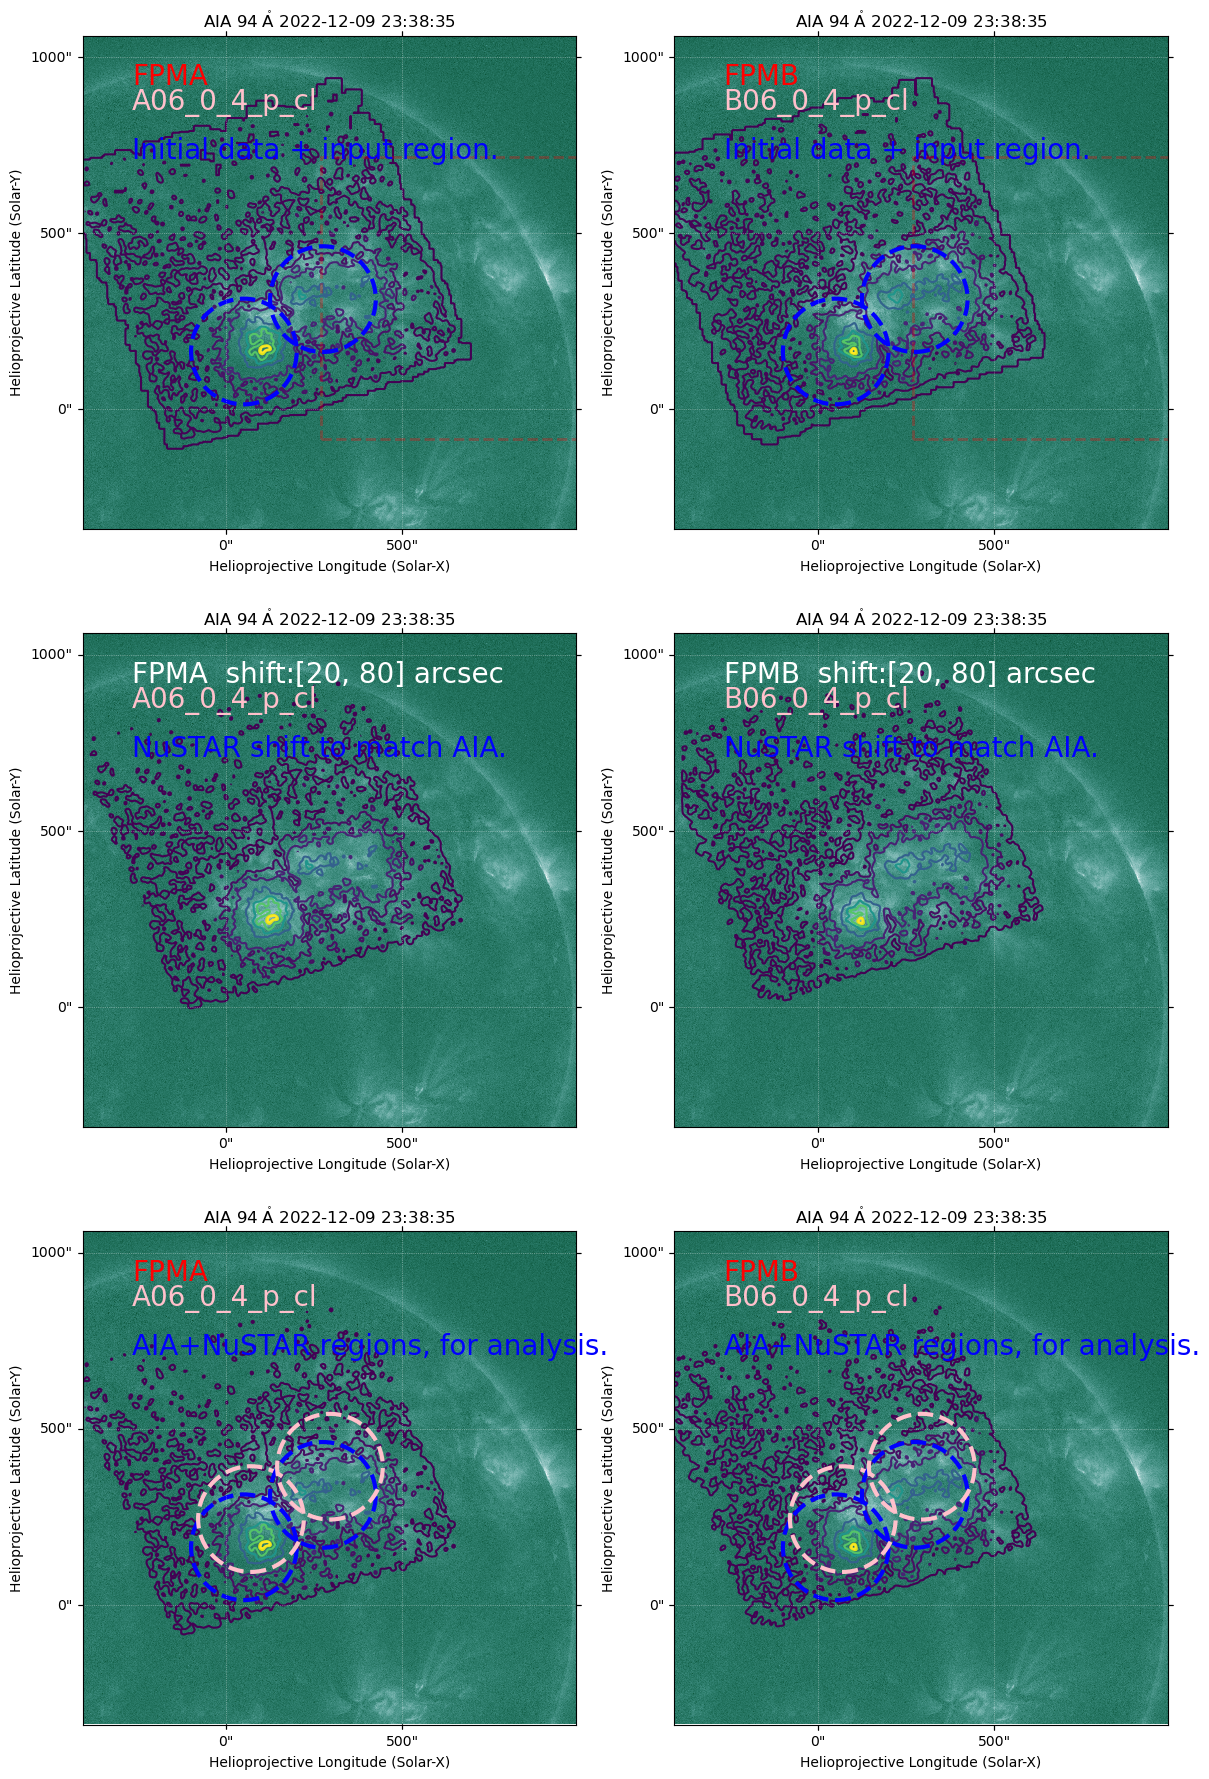

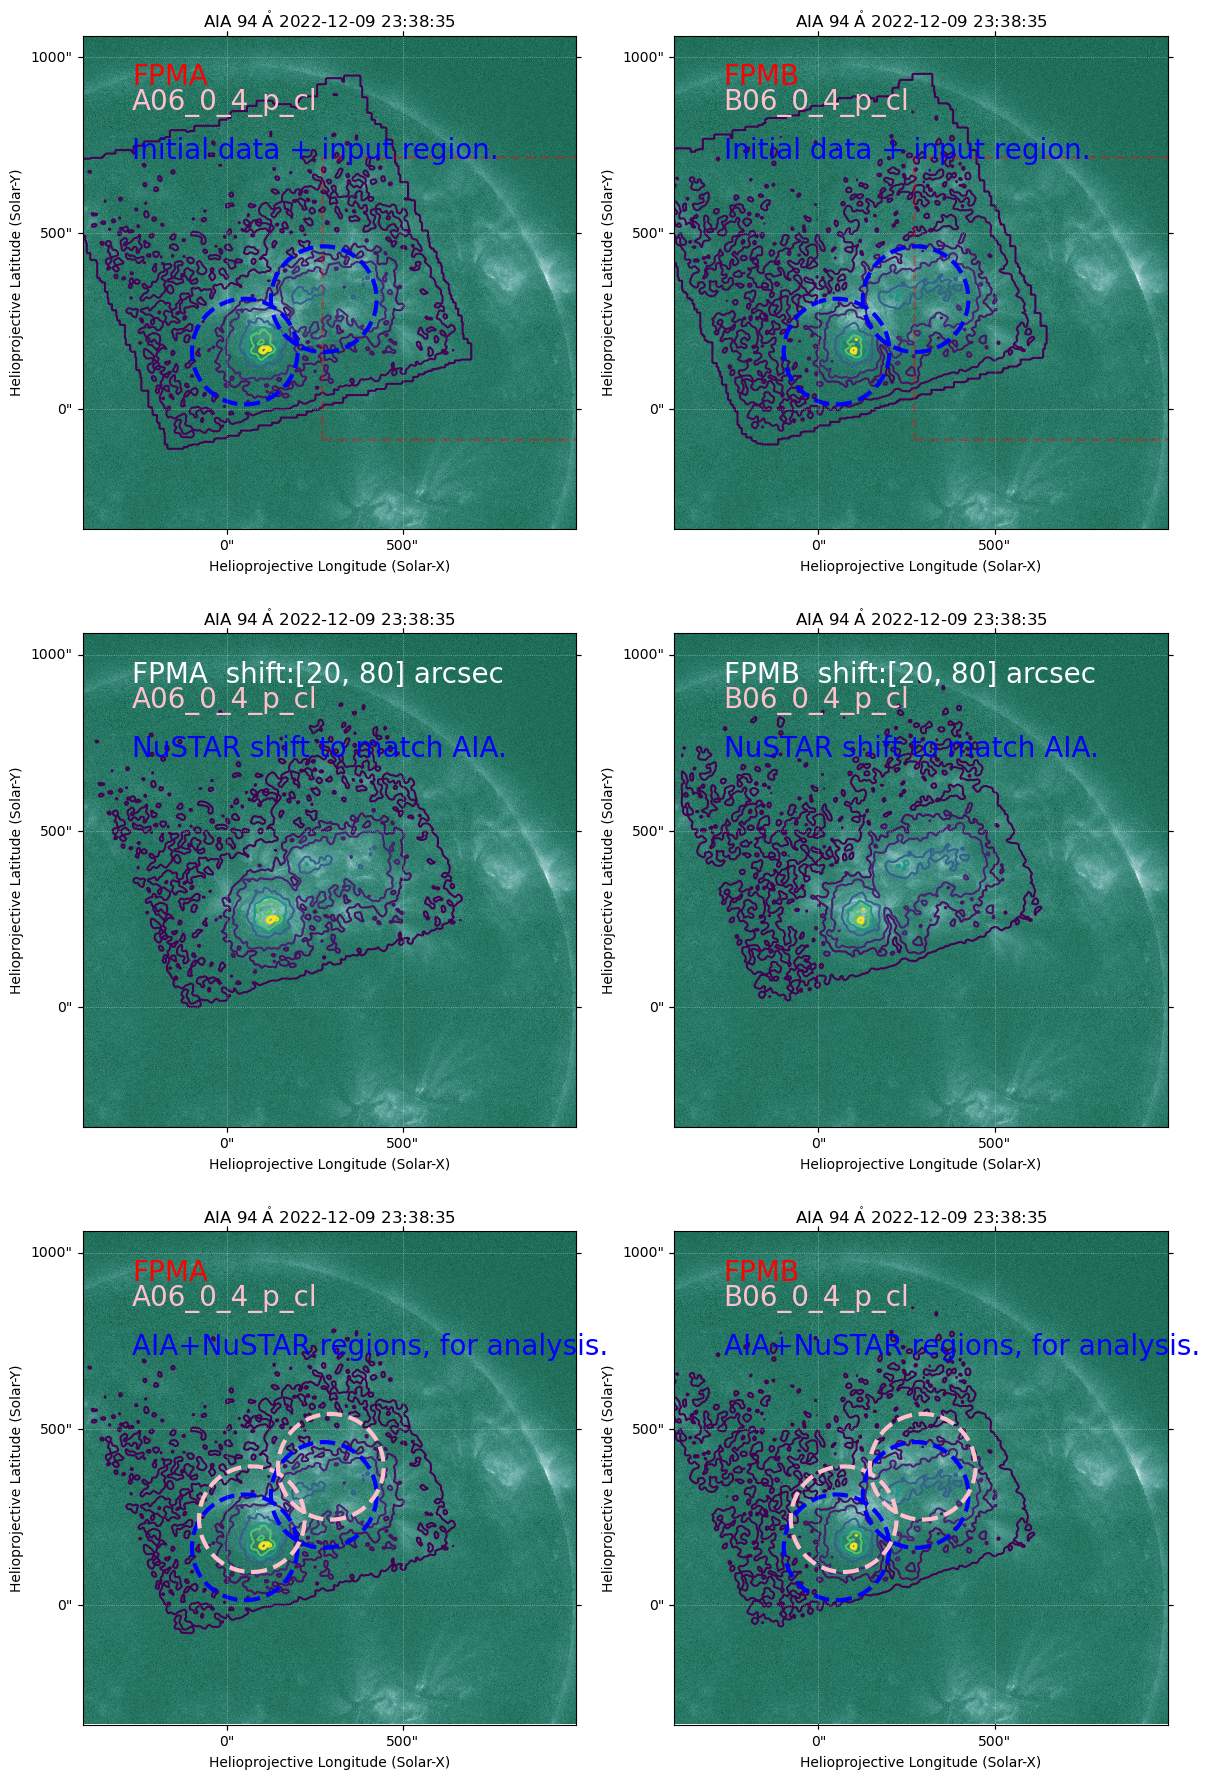

In [11]:
#Do region adjustment
importlib.reload(iac)

pick_region = True

regdicts_all = []
for j in range(0, len(aagt)):
    regdicts=[]
    for i in range(0, len(id_dirs)):
        #print('AAGT:', aagt[j][i])
        if not aagt[j][i]:
            regdicts.append([])
            continue
        aati = iac.per_orbit_region_adjustment(ARDict, i, aiamaps, 
                                                    nushift=shiftt, method=method, shush=True, 
                                                    sep_axis=sep_axis, show=True,
                                                    pick_region=pick_region, regionind=j)
    
        #append new region dictionary to list
        if method == 'fit':
                regdicts.append(aati['aiaregdicts'][0])
        else:
            regdicts.append(aati['aiaregdicts'][0])

    regdicts_all.append(regdicts)

#Updates to obs-key dictionary:
ARDict['nushift'] = shiftt
ARDict['regdicts'] = regdicts_all

all_targets[key] = ARDict

with open(file, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_targets, f, pickle.HIGHEST_PROTOCOL) 

In [16]:
#Older verion - making files for NCCS

# importlib.reload(iac)

# if method in ['input', 'double']:
#     if method=='input':
#         region_dirs = iac.find_region_dirs(working_dir)
#     if method=='double':
#         region_dirs = iac.find_direction_dirs(working_dir, sep_axis)

#     for r in region_dirs:
#         all_time_intervals, all_time_intervals_list = tis.find_all_intervals(r)
#         suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, r, key, additional_path=working_dir)

# if method=='fit':
#     all_time_intervals, all_time_intervals_list = tis.find_all_intervals(working_dir)
#     suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, working_dir, key)

0 - 0 11-12-35 11-20-10
0 - 1 11-20-10 11-22-50
0 - 2 11-22-50 11-23-35
0 - 3 11-23-35 11-24-50
0 - 4 11-24-50 11-28-30
0 - 5 11-28-30 11-47-15
0 - 6 11-47-15 11-53-55

1 - 0 16-05-50 16-06-20
1 - 1 16-06-20 16-06-50
1 - 2 16-06-50 16-07-20
1 - 3 16-07-20 16-07-50
1 - 4 16-07-50 16-08-30
1 - 5 16-08-30 16-09-10
1 - 6 16-09-10 16-10-15
1 - 7 16-10-15 16-18-30
1 - 8 16-18-30 16-24-25
1 - 9 16-24-25 16-30-50
1 - 10 16-30-50 16-32-45
1 - 11 16-32-45 16-41-10
1 - 12 16-41-10 17-07-45

2 - 0 17-48-35 17-56-00

3 - 0 19-18-50 19-24-40
3 - 1 19-24-40 19-28-25
3 - 2 19-28-25 19-28-55
3 - 3 19-28-55 19-29-25
3 - 4 19-29-25 19-29-55
3 - 5 19-29-55 19-30-25
3 - 6 19-30-25 19-32-00
3 - 7 19-32-00 19-41-15
3 - 8 19-41-15 19-48-50
3 - 9 19-48-50 19-49-30
3 - 10 19-49-30 19-50-00
3 - 11 19-50-00 19-50-30
3 - 12 19-50-30 19-51-00
3 - 13 19-51-00 19-52-15
3 - 14 19-52-15 19-53-20
3 - 15 19-53-20 19-55-05
3 - 16 19-55-05 19-56-50
3 - 17 19-56-50 20-16-25

4 - 0 20-52-30 20-56-05
4 - 1 20-56-05 21-03-05
4

In [3]:
# # firl = '/Users/jmdunca2/do-dem/initial_dem_8jun20/19-54-59_20-00-54/19-54-59_20-00-54_aia_region.pickle'
# #firl = '/Users/jmdunca2/do-dem/initial_dem_11sep17/all_aia_dicts_11-sep-17_post/orbit_80310212001/17-32-30_17-33-00_aia_prep.pickle'
# #firl = '/Users/jmdunca2/do-dem/initial_dem_19feb16/all_aia_dicts_19-feb-16/orbit_20102014001/23-44-55_00-09-50_aia_prep.pickle'
# #firl = '/Users/jmdunca2/do-dem/initial_dem_29may18_2/all_aia_dicts_29-may-18_2/orbit_80410206001/21-16-55_21-24-25_aia_prep.pickle'
# firl = '/Users/jmdunca2/do-dem/initial_dem_22apr16_2/all_aia_dicts_22-apr-16_2/orbit_20101017001/17-20-55_18-11-15_aia_prep.pickle'


# #orbit_20101019001/20-24-30_20-38-45_aia_prep.pickle
# #orbit_20101020001/22-01-10_22-06-25_aia_prep.pickle

# with open(firl, 'rb') as f:
#     data = pickle.load(f)

# print(data.keys())
# data

dict_keys(['radius', 'centerx', 'centery', 'time_interval'])


{'radius': 150.0,
 'centerx': <Quantity 984.38365922 arcsec>,
 'centery': <Quantity 224.78472196 arcsec>,
 'time_interval': <Time object: scale='utc' format='datetime' value=[datetime.datetime(2016, 4, 22, 17, 20, 55)
  datetime.datetime(2016, 4, 22, 18, 11, 15)]>}

In [ ]:
# dict_={}
# dict_['hi'+str(0)]='hey'
# dict_

In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals:
#     lead_intervals.append(at[0])

# reference_interval=time_interval


# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
# importlib.reload(oa)
# import pickle

# orbit_ind=0

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[0, 0]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# #IF YOU WANT TO REVISE THE STARTING SHIFT SOMEWHERE OTHER THAN JUST AT THE VERY FIRST ORBIT - NEXT 2 CELLS

# importlib.reload(oa)
# import pickle

# orbit_ind=3

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[30, -40]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals[3:]:
#     lead_intervals.append(at[0])

# reference_interval=time_interval

# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
importlib.reload(oa)
suborbit_dirs = oa.make_all_aia_dicts(all_time_intervals, working_dir, key)
print(set(suborbit_dirs))

In [ ]:
# import glob

# #Set path to obsid directory - initial pipeline should have been run already.
# ind=0
# datapath=id_dirs[ind]
# obsid=obsids[ind]

# evt_data, hdr = ia.return_submap(datapath=datapath, fpm='A', return_evt_hdr=True)
# time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
# timerange = [time0.tt.datetime, time1.tt.datetime]
# from datetime import timezone
# timerange = [t.replace(tzinfo=timezone.utc) for t in timerange]

# #Comment second line if you're not using this same example nustar orbit
# #Edit it to include only the desired time interval (default- all times in file) once you've run this once
# #timerange=[]
# #timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

# evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
# evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
# hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
# hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

# import lightcurves as lc

# importlib.reload(lc)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
#                               livetime_corr=False, save_dir=working_dir)

# lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
#                            timerange=timerange, save_dir=working_dir)